In [145]:
import wave as wave
import numpy as np
import pyroomacoustics as pa
import scipy.signal as sp
import matplotlib.pyplot as plt

def calculate_steering_vector(mic_alignments, source_locations, freqs, sound_speed=340, is_use_far=True):
    n_channels = np.shape(mic_alignments)[1]
    print(n_channels)

    n_sources = np.shape(source_locations)

    if is_use_far == True:
        norm_source_locations = source_locations/np.linalg.norm(source_locations, 2, axis=0, keepdims=True)
        #print("norm_source_locations:\n", norm_source_locations[..., None], "\n")
        #print("mic_alignments:\n", mic_alignments[:, None, :])

        steering_phase = np.einsum('k,ism,ism->ksm', 2.j*np.pi/sound_speed*freqs, norm_source_locations[..., None], mic_alignments[:, None, :])
        steering_vector = 1./np.sqrt(n_channels)*np.exp(steering_phase)

        return steering_vector

def display_DSBF_spectrum(stft_data: np.ndarray, far_steering_vectors, start_angle: float, end_angle: float, divisions: int, frame_num: int):
    # 時間数 x 音源方向数
    spectrum = np.empty((0, far_steering_vectors.shape[1]))
    stft_data_inv = np.transpose(stft_data, axes=(1, 0, 2)).conj()
    print(stft_data.shape)
    set_index = 1
    while True:
        mean_start_index = (set_index-1)*frame_num
        mean_end_index = set_index*frame_num
        
        if mean_start_index >= stft_data.shape[2]:
            break
        if mean_end_index > stft_data.shape[2]:
            mean_end_index = stft_data.shape[2]
        
        zz = np.einsum("mkt,knt->kmn", stft_data[:, :, mean_start_index:mean_end_index], stft_data_inv[:, :, mean_start_index:mean_end_index]) / frame_num
        temp_spectrum = np.einsum("ksm,kmn,ksn->s", far_steering_vectors.conj(), zz, far_steering_vectors)/np.einsum("ksm,ksn->s", far_steering_vectors.conj(), far_steering_vectors)
        # とりあえず全周波数ビンで和を取ることにしたが、正しい算出方法はわからない
        spectrum = np.append(spectrum, [abs(temp_spectrum)], axis=0)
        set_index += 1
    # print(spectrum)
    # print(spectrum.shape)
    print(spectrum)
    angles = np.linspace(start_angle, end_angle, divisions+1)
    plt.imshow(spectrum.T, interpolation="nearest", aspect="auto", extent=[0, spectrum.shape[1], start_angle, end_angle])
    plt.colorbar()
    plt.ylabel("Direction of Arrival")
    plt.xlabel("Time [frame]")
    plt.show()
    

#2バイトに変換してファイルに保存
#signal: time-domain 1d array (float)
#file_name: 出力先のファイル名
#sample_rate: サンプリングレート
def write_file_from_time_signal(signal,file_name,sample_rate):
    #2バイトのデータに変換
    signal=signal.astype(np.int16)

    #waveファイルに書き込む
    wave_out = wave.open(file_name, 'w')

    #モノラル:1、ステレオ:2
    wave_out.setnchannels(1)

    #サンプルサイズ2byte
    wave_out.setsampwidth(2)

    #サンプリング周波数
    wave_out.setframerate(sample_rate)

    #データを書き込み
    wave_out.writeframes(signal)

    #ファイルを閉じる
    wave_out.close()



In [146]:
# 音を生成
np.random.seed(0)
clean_wave_files=["./CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"]
n_sources = len(clean_wave_files)
n_samples = 0

for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    if n_samples < wav.getnframes():
        n_samples = wav.getnframes()
    wav.close()

clean_data = np.zeros([n_sources, n_samples])

s = 0
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data/np.iinfo(np.int16).max
    clean_data[s, :wav.getnframes()] = data
    wav.close()
    s = s + 1

sample_rate = 16000
N = 1024
Nk = N/2 + 1
freqs = np.arange(0, Nk, 1) * sample_rate / N
SNR = 20.
room_dim = np.r_[10.0, 10.0, 10.0]

mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1

# mic_alignments = np.array(
#     [
#         [-0.01, 0.0, 0.0],
#         [0.01, 0.0, 0.0],
#     ]
# )

mic_alignments = np.array(
    [[x, 0.0, 0.0] for x in np.arange(-0.31, 0.32, 0.02)]
)

R = mic_alignments .T + mic_array_loc[:, None]

n_channels = np.shape(mic_alignments)[0]
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
doas = np.array([[np.pi/2., 0]])
distance = 1

source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]
real_sl = source_locations
print("source_locations: ", source_locations)

for s in range(n_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])

room.simulate(snr=SNR)




source_locations:  [[6.17640523]
 [5.04001572]
 [5.0978738 ]]


source_locations: 
 [[4.17640523 4.22534872 4.36738824 4.58861998 4.86738824 5.17640523
  5.48542223 5.76419049 5.98542223 6.12746175 6.17640523 6.12746175
  5.98542223 5.76419049 5.48542223 5.17640523 4.86738824 4.58861998
  4.36738824 4.22534872]
 [5.04001572 4.73099873 4.45223047 4.23099873 4.0889592  4.04001572
  4.0889592  4.23099873 4.45223047 4.73099873 5.04001572 5.34903272
  5.62780097 5.84903272 5.99107224 6.04001572 5.99107224 5.84903272
  5.62780097 5.34903272]
 [5.0978738  5.0978738  5.0978738  5.0978738  5.0978738  5.0978738
  5.0978738  5.0978738  5.0978738  5.0978738  5.0978738  5.0978738
  5.0978738  5.0978738  5.0978738  5.0978738  5.0978738  5.0978738
  5.0978738  5.0978738 ]]
32
(32, 62224)
3.904
(32, 513, 123)
[[1.73042310e-02 1.86069000e-02 2.06964897e-02 2.34508784e-02
  2.66480192e-02 2.98733052e-02 3.26477484e-02 3.46133811e-02
  3.55252012e-02 3.53144550e-02 3.40691350e-02 3.20008762e-02
  2.93928427e-02 2.65299341e-02 2.37308795e-02 2.12480909e-02
  1.9214950

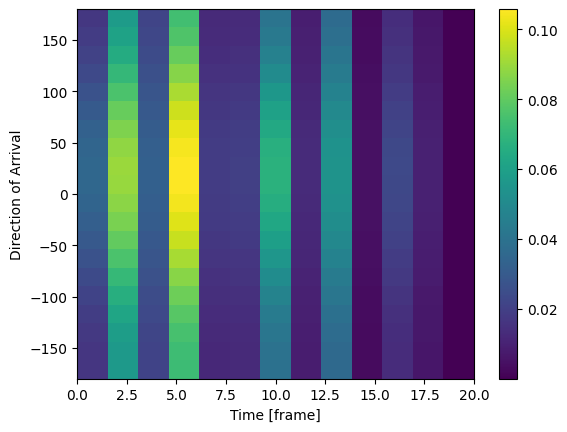

In [149]:
# 方向をスキャンするコードを生成
# マイクの位置を0としたシミュレーションの音声波形を生成
# スキャンしたスペクトルを描画->スペクトルはどの値をとる？
#    ->音のアレイ信号処理 p.103より、スペクトルはステアリング方向を変化させたときの各角度についての平均出力パワーをスペクトルとすればいいらしい。
import numpy as np

angles = np.linspace(-np.pi, np.pi, 20+1)
doas = np.hstack((np.full((angles.size-1, 1), np.pi/2.), angles[:20, None]))
# print(doas)

sample_rate = 16000
N = 1024 # フレームサイズ
Nk = N / 2 + 1
freqs = np.arange(0, Nk, 1) * sample_rate / N
# print(freqs)

source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)

source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance

source_locations += mic_array_loc[:, None]
print("source_locations: \n", source_locations)
# source_locations = real_sl

# print(source_locations)
# ステアリングベクトルを計算
# 音源数であるsが20個あり、これが方向に対応する
far_steering_vectors = calculate_steering_vector(R, source_locations, freqs, sound_speed=340, is_use_far=True)

multi_conv_data = room.mic_array.signals # 時間領域でデータを取得 shapeは(M, 時間インデックス数)
print(multi_conv_data.shape)
write_file_from_time_signal(multi_conv_data[0] * np.iinfo(np.int16).max/20., "./mix_in.wav", sample_rate)

f,t,stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)
print(t[t.size-1])

s_hat = np.einsum("ksm,mkt->skt", np.conjugate(far_steering_vectors), stft_data)
c_hat = np.einsum("skt,ksm->mskt", s_hat, far_steering_vectors)

t, ds_out = sp.istft(c_hat[0], fs=sample_rate, window="hann", nperseg=N)
ds_out = ds_out*np.iinfo(np.int16).max/20.
write_file_from_time_signal(ds_out, "./ds_out.wav", sample_rate)

# スペクトル1つを生成するためのフレーム数
frame_num = 10
# print(stft_data.shape)
stft_data_inv = np.transpose(stft_data, axes=(1, 0, 2)).conj()

display_DSBF_spectrum(stft_data, far_steering_vectors, start_angle=-180., end_angle=180., divisions=20, frame_num=10)

